In [19]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('./portfolio_value_fair_value_data.csv')

# Drop rows with any NaN values
df = df.dropna()

# Drop the ticker column
df = df.drop(columns=['Ticker'])

# Handle Categorical Variables
df = pd.get_dummies(df)
df = df.apply(pd.to_numeric, errors='coerce')

# Check for NaN values after conversion and drop rows with NaN values
df = df.dropna()

# Ensure only numeric columns are considered for outlier removal
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Identify outliers using IQR
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Filter out the outliers
df_outliers_removed = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Original data shape: {df.shape}")
print(f"Data shape after outlier removal: {df_outliers_removed.shape}")

# Redefine features and target after removing outliers
X = df_outliers_removed.drop(columns=['Fair Value'])
y = df_outliers_removed['Fair Value']
features = X.columns

# Log transformation of skewed features
skewed_feats = X.apply(lambda x: np.abs(x.skew())).sort_values(ascending=False)
skewed_features = skewed_feats[skewed_feats > 0.75].index
for feat in skewed_features:
    X[feat] = np.log1p(X[feat])

# Check for any remaining NaN values after log transformation
X = X.fillna(0)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the XGBoost model again
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=200, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8)
xgb.fit(X_train, y_train)

# Evaluate the model
y_pred_xgb = xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model Performance - MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")


Original data shape: (452, 76)
Data shape after outlier removal: (46, 76)


/home/odhran_user/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


XGBoost Model Performance - MAE: 74.01, MSE: 11206.35, R²: -0.01


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load the dataset
df = pd.read_csv('./portfolio_value_fair_value_data.csv')

# Drop rows with any NaN values
df = df.dropna()

# Drop the ticker column
df = df.drop(columns=['Ticker'])

# Convert all columns to numeric, coercing errors to NaN
df = pd.get_dummies(df)
df = df.apply(pd.to_numeric, errors='coerce')

# Check for NaN values after conversion and drop rows with NaN values
df = df.dropna()

# Step 2: Define features and target
X = df.drop(columns=['Fair Value'])
y = df['Fair Value']
features = X.columns

# Step 3: Normalize features and target variable
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize the target variable
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_xgb = y_pred_xgb * y_std + y_mean  # Unnormalize the predictions
y_test_unnorm = y_test * y_std + y_mean  # Unnormalize the target

mae = mean_absolute_error(y_test_unnorm, y_pred_xgb)
mse = mean_squared_error(y_test_unnorm, y_pred_xgb)
r2 = r2_score(y_test_unnorm, y_pred_xgb)

print(f"XGBoost Model Performance - MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; tot

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
file_path = './portfolio_value_fair_value_data.csv'
df = pd.read_csv(file_path)

# Drop rows with any NaN values
df = df.dropna()

# Drop the ticker column
df = df.drop(columns=['Ticker'])

# Handle Categorical Variables
df = pd.get_dummies(df)

# Convert all columns to numeric, forcing non-convertible values to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values after conversion
df = df.dropna()

# Ensure 'Fair Value' column is present
if 'Fair Value' not in df.columns:
    raise ValueError("'Fair Value' column is not found in the dataset.")

# Define features and target
X = df.drop(columns=['Fair Value'])
X = X / 100
y = df['Fair Value']

# Step 1: Correlation Matrix to Remove Highly Correlated Features
corr = X.corr()
high_corr_var = np.where(corr > 0.9)
high_corr_var = [(corr.index[x], corr.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

for feature_pair in high_corr_var:
    print(f"Removing highly correlated feature pair: {feature_pair}")
    X = X.drop(columns=[feature_pair[1]])

features = X.columns.tolist()

# Step 2: Feature Importance Using Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n_features = [features[i] for i in indices[:20]]
X_top_features = X[top_n_features]

# Step 3: Recursive Feature Elimination (RFE)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=20)  # Adjust the number of features to select
fit = rfe.fit(X, y)
selected_features_rfe = [features[i] for i in range(len(features)) if fit.support_[i]]

# Step 4: Variance Threshold
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
selector.fit(X)
selected_features_var = [features[i] for i in range(len(features)) if selector.get_support()[i]]

# Step 5: Combine and deduplicate feature sets from the steps above
final_selected_features = list(set(top_n_features + selected_features_rfe + selected_features_var))
X_final = X[final_selected_features]

# Ensure X_final is entirely numeric before proceeding
X_final = X_final.apply(pd.to_numeric, errors='coerce')
X_final = X_final.dropna(axis=1, how='all')

# Verify all columns are numeric
for column in X_final.columns:
    if not pd.api.types.is_numeric_dtype(X_final[column]):
        print(f"Non-numeric column found: {column}")
        X_final = X_final.drop(columns=[column])

# Step 6: Remove Outliers by calculating Z-scores manually
mean = X_final.mean()
std = X_final.std()
z_scores = (X_final - mean) / std
X_final_outliers_removed = X_final[(np.abs(z_scores) < 3).all(axis=1)]
y_outliers_removed = y.loc[X_final_outliers_removed.index]

# Step 7: Log transformation of skewed features
skewed_feats = X_final_outliers_removed.apply(lambda x: np.abs(x.skew())).sort_values(ascending=False)
skewed_features = skewed_feats[skewed_feats > 0.75].index
for feat in skewed_features:
    X_final_outliers_removed[feat] = np.log1p(X_final_outliers_removed[feat])

# Check for any remaining NaN values after log transformation
X_final_outliers_removed = X_final_outliers_removed.fillna(0)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final_outliers_removed)

# Split the data into training and testing sets
X_train_final, X_test_final, y_train, y_test = train_test_split(X_scaled, y_outliers_removed, test_size=0.2, random_state=42)

# Train the XGBoost model again
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=200, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8)
xgb.fit(X_train_final, y_train)

# Evaluate the model
y_pred_xgb = xgb.predict(X_test_final)

mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model Performance - MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")


Removing highly correlated feature pair: ('Operating Cash Flow', 'Cash Flow 1')
Removing highly correlated feature pair: ('DCF Value', 'DCF Valuation Ratio')
Removing highly correlated feature pair: ('P/S Ratio', 'Enterprise to Revenue')


/tmp/ipykernel_72392/1077797053.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_final_outliers_removed[feat] = np.log1p(X_final_outliers_removed[feat])
/home/odhran_user/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


XGBoost Model Performance - MAE: 47.55, MSE: 4966.26, R²: 0.81


In [40]:
import pandas as pd
import numpy as np

# Load the dataset for sample prediction
sample_data = pd.read_csv('dell.csv')

# Convert the sample data to a DataFrame
sample_df = pd.DataFrame(sample_data)

# Preprocess the sample data
# Handle categorical variables
sample_df = pd.get_dummies(sample_df)

# Ensure all expected columns are present in the sample data
missing_cols = set(X_final.columns) - set(sample_df.columns)
for col in missing_cols:
    sample_df[col] = 0

# Ensure the columns are in the same order as the training data
sample_df = sample_df[X_final.columns]

# Convert to numeric and fill any NaNs
sample_df = sample_df.apply(pd.to_numeric, errors='coerce')
sample_df = sample_df.fillna(0)

# Apply the same division by 100 to the sample data
sample_df = sample_df / 100

# Scale the sample data
sample_scaled = scaler.transform(sample_df)

# Make a prediction
sample_prediction = xgb.predict(sample_scaled)

# Output the prediction
print(f"Predicted Fair Value: {sample_prediction[0]}")

# Debugging: Print intermediate steps
print("\nSample Data (First Few Rows):")
print(sample_df.head())

print("\nSample Data (Scaled):")
print(sample_scaled[:5])

print("\nFeature Importance from the Model:")
feature_importances = xgb.feature_importances_
for name, importance in zip(X_final.columns, feature_importances):
    print(f"{name}: {importance}")

# Check consistency with the training data (Optional)
print("\nTraining Data (First Few Rows):")
print(X_final.head())


Predicted Fair Value: 206.4453887939453

Sample Data (First Few Rows):
   Operating Margin  Strong Buy  Debt Weight  Economic Value Added  \
0          0.000455        0.12     0.001972         -3.958697e+06   

   Cash Flow 4  Enterprise to EBITDA  Interest Expense     DCF Value  \
0   93250000.0               0.14049        15010000.0  4.942166e+10   

   Debt to Asset Ratio  Total Cash Per Share  ...  Quick Ratio  P/FCF Ratio  \
0                  0.0               0.08219  ...      0.00399     0.204139   

   Sector_Energy  Sustainable Growth Rate      ROIC  DDM Valuation Ratio Max  \
0            0.0                      0.0  0.001068                      0.0   

   Sector_Financial Services  Cash Flow 2       Revenue  Sector_Technology  
0                        0.0    5620000.0  8.974700e+08               0.01  

[1 rows x 53 columns]

Sample Data (Scaled):
[[-1.24089422e+00 -2.42870319e-01  4.30785172e-02 -5.36957843e+05
   2.36390628e+00 -1.13214213e-01  5.57040774e+06  9.0168

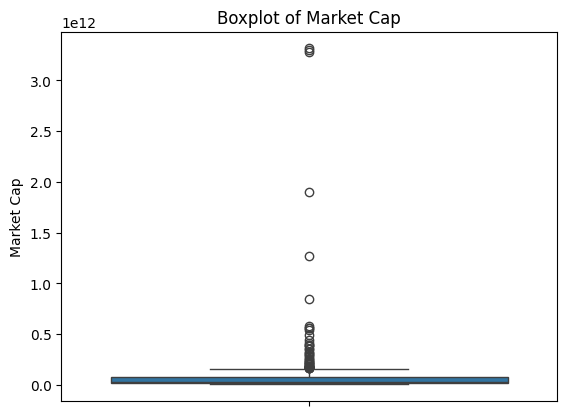

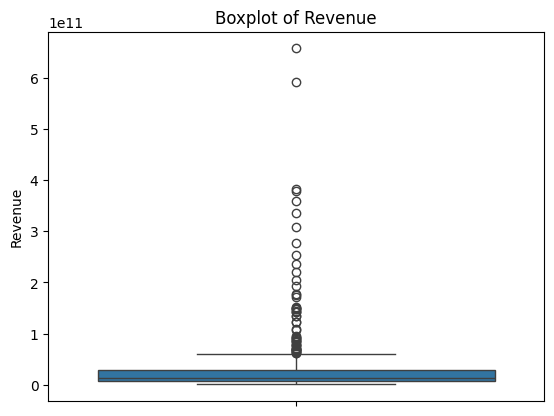

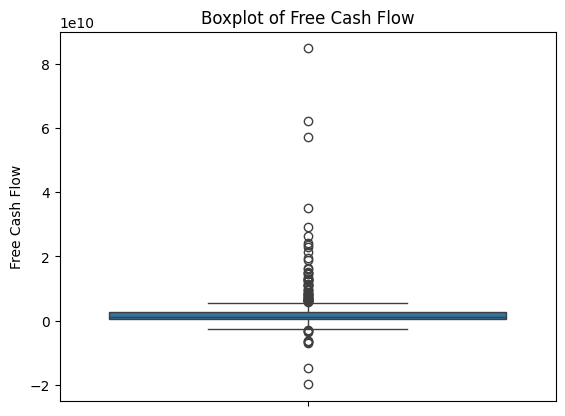

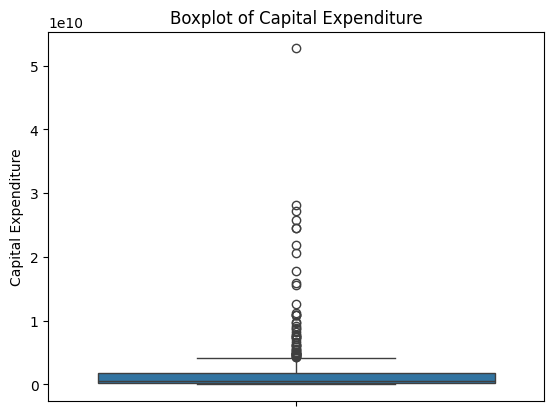

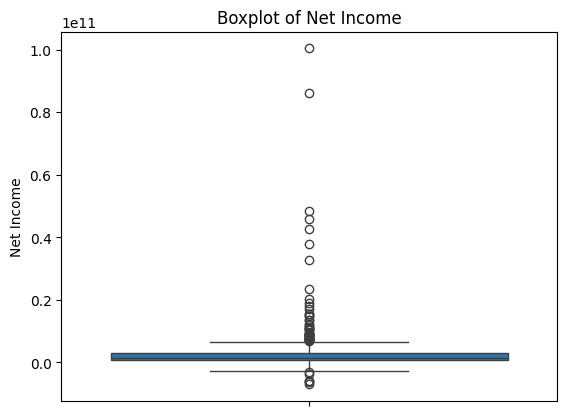

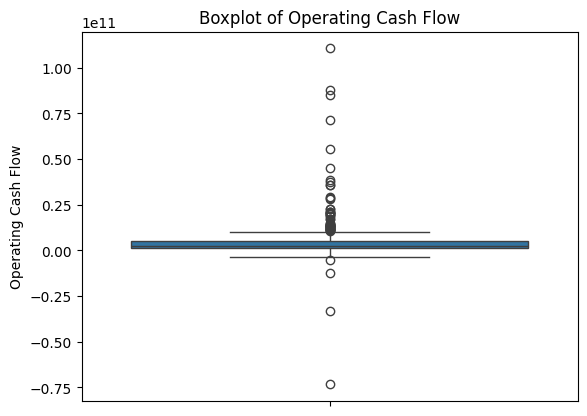

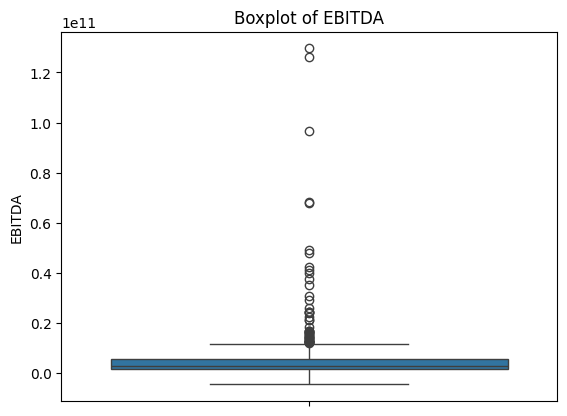

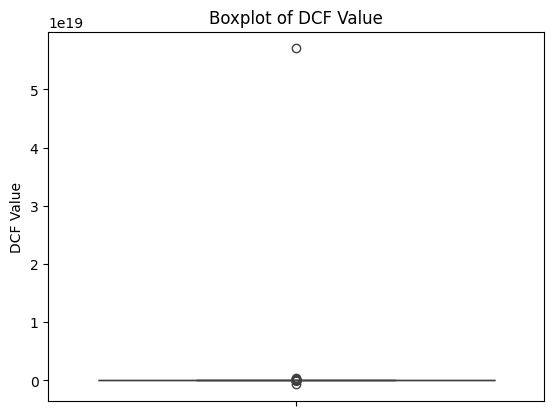

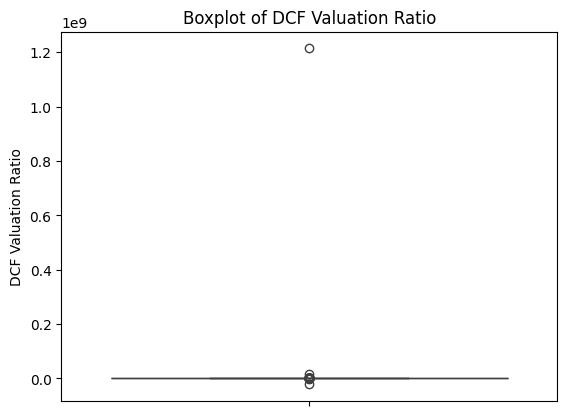

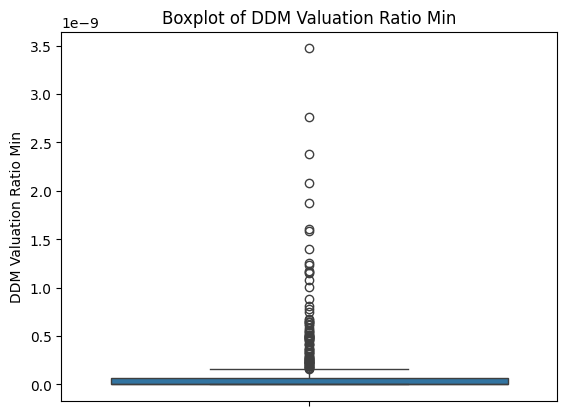

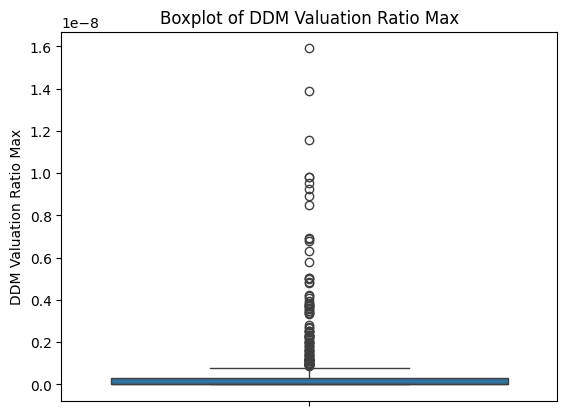

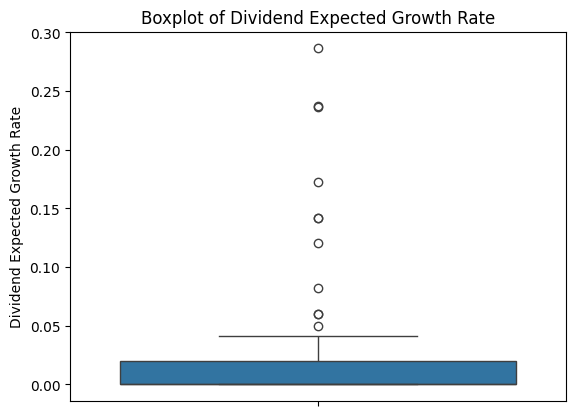

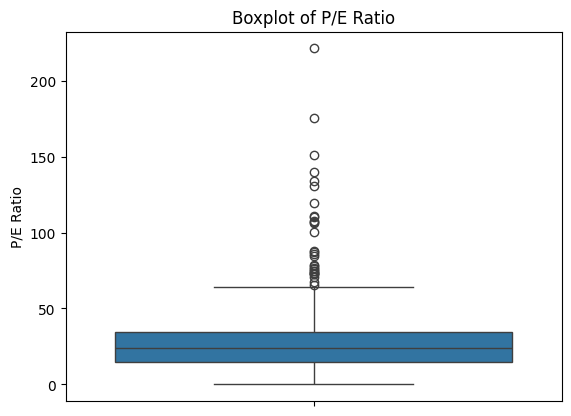

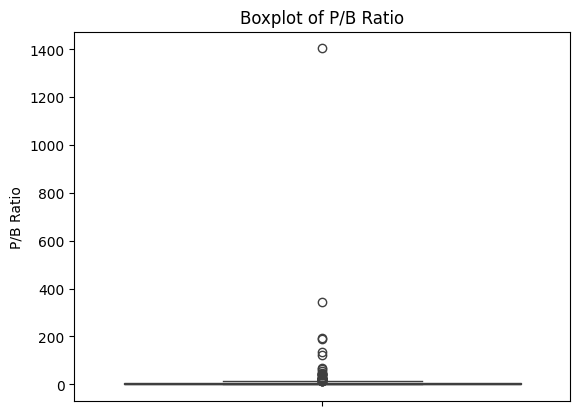

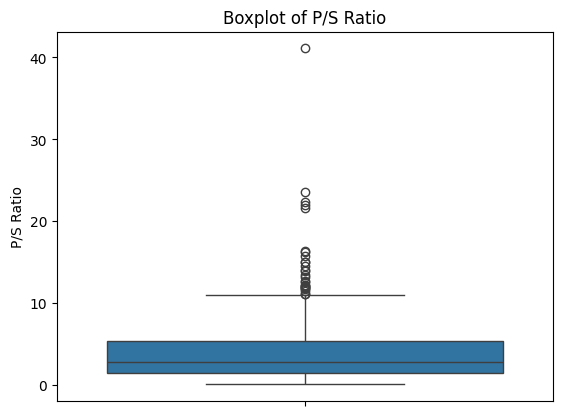

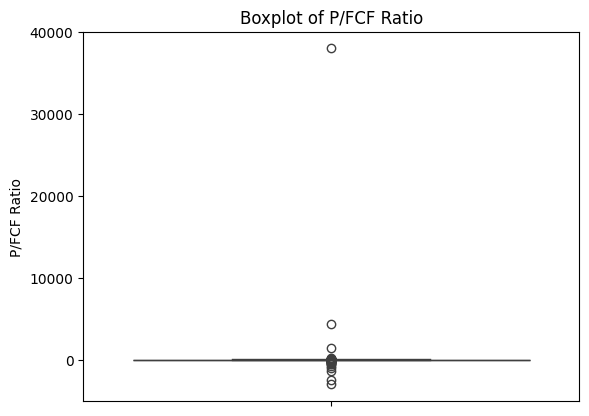

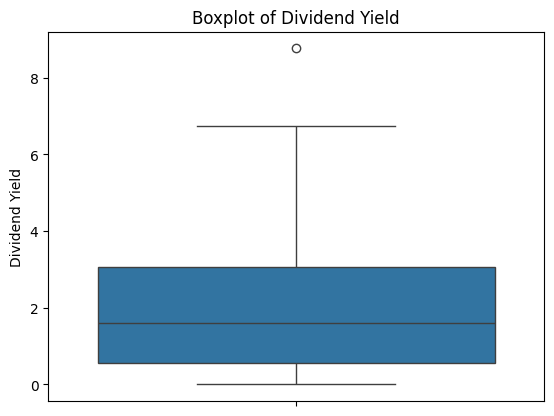

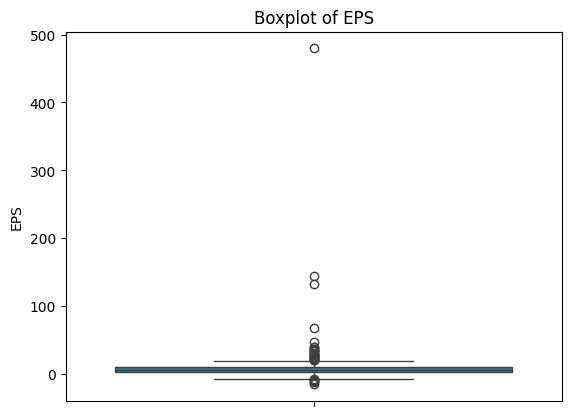

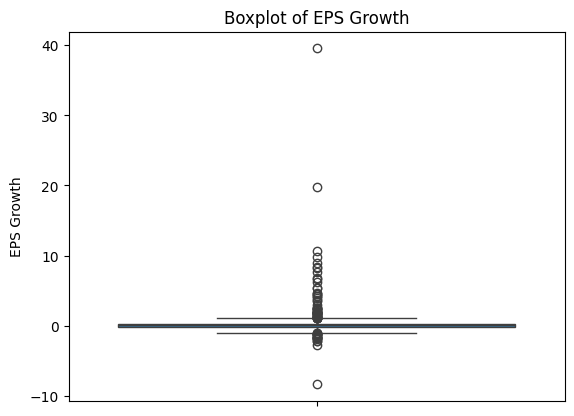

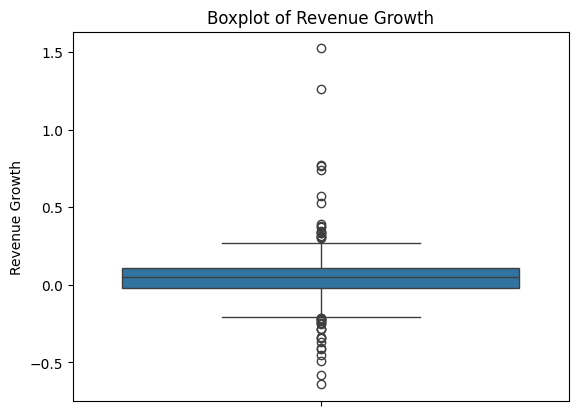

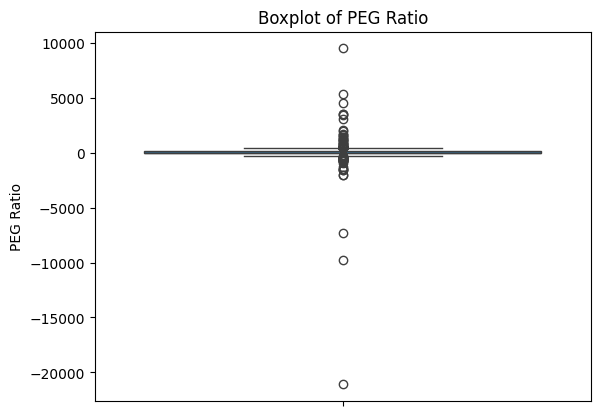

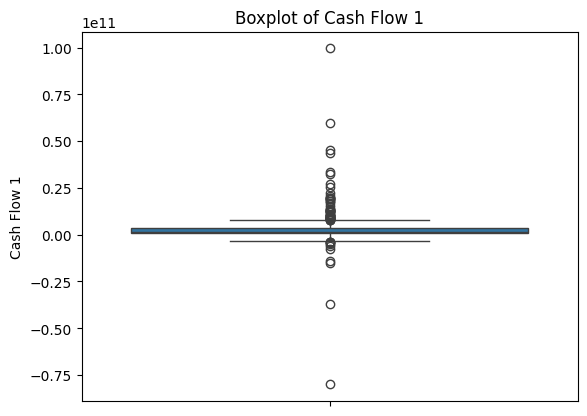

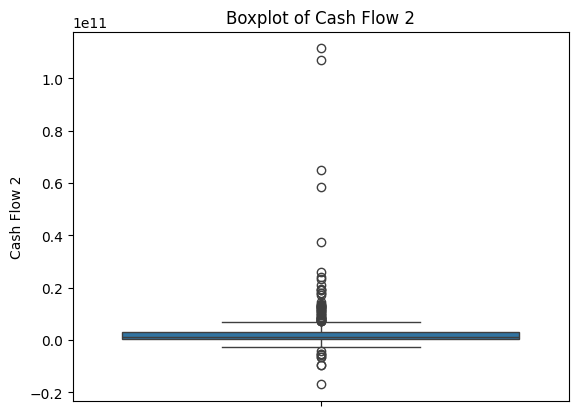

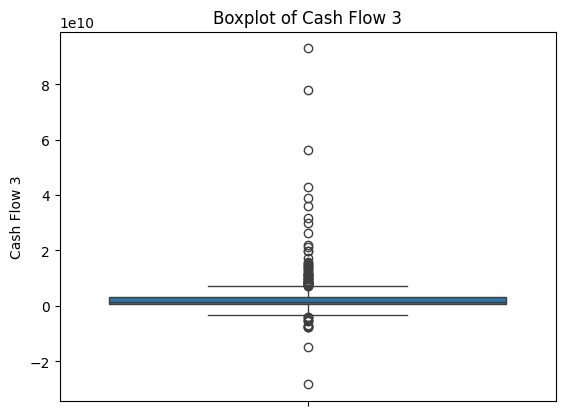

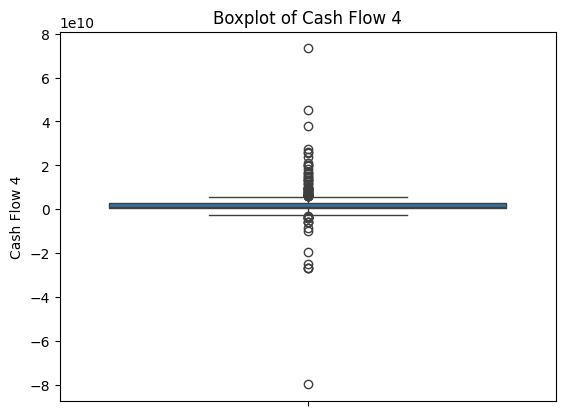

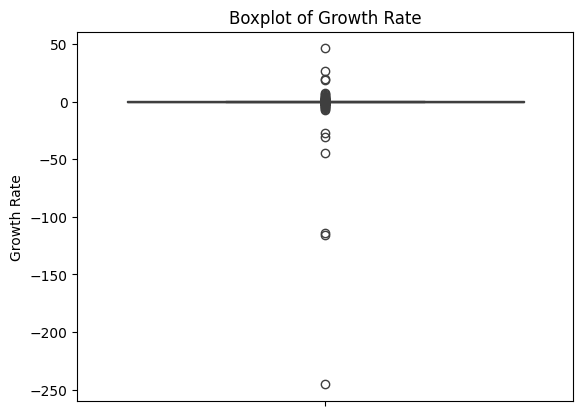

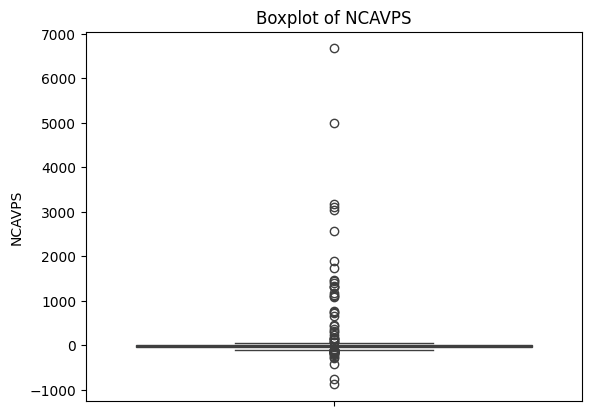

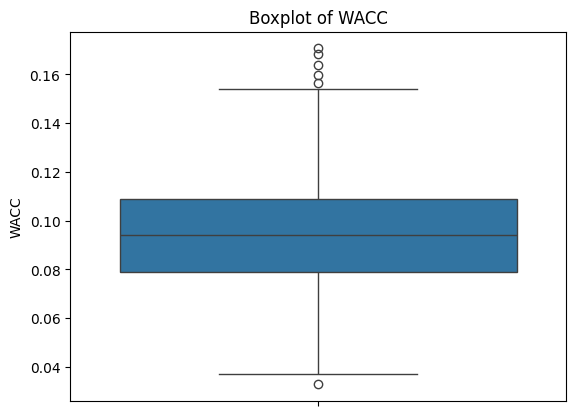

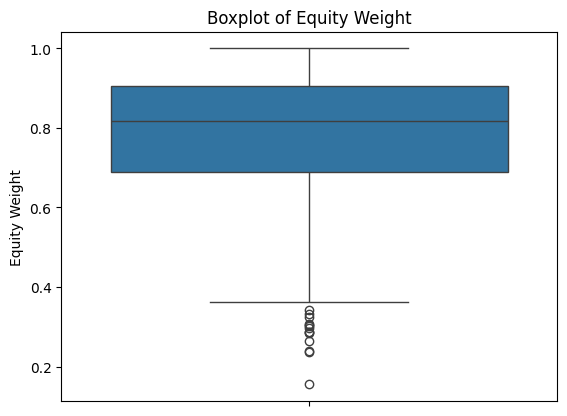

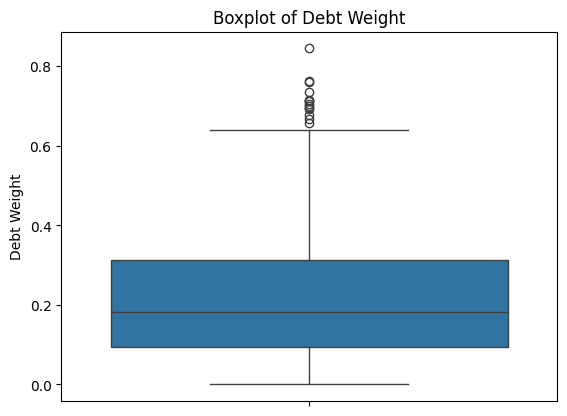

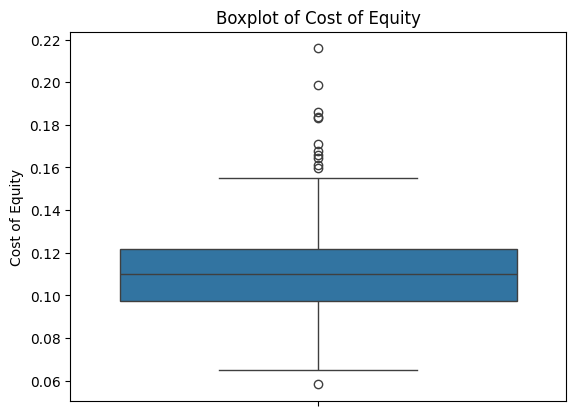

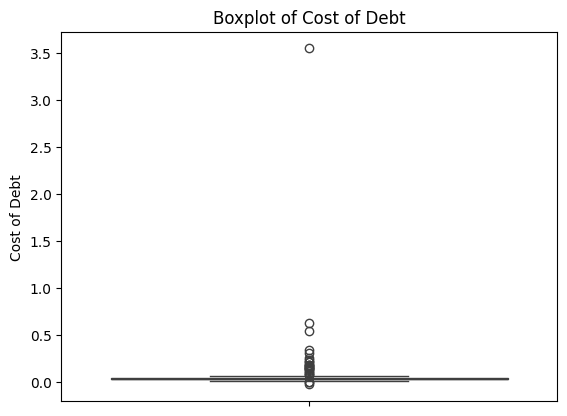

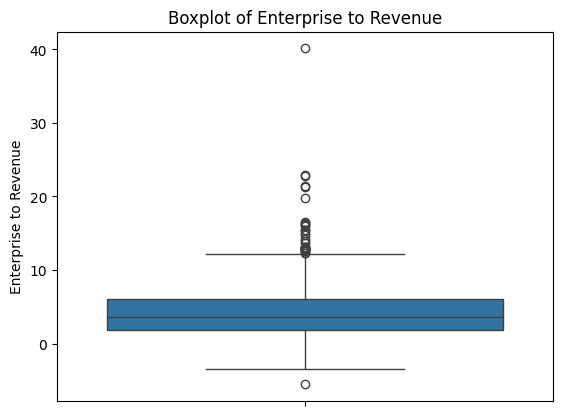

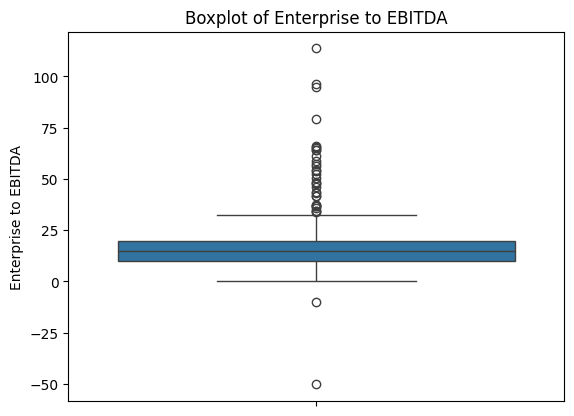

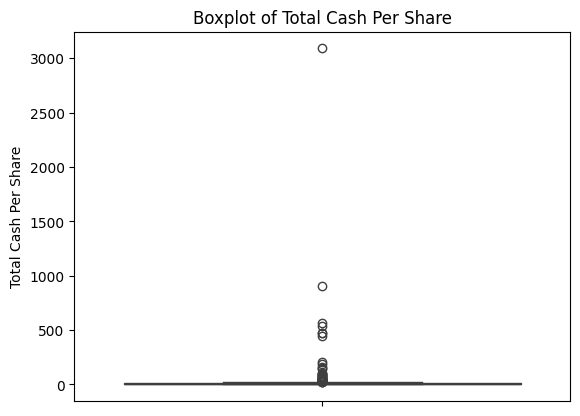

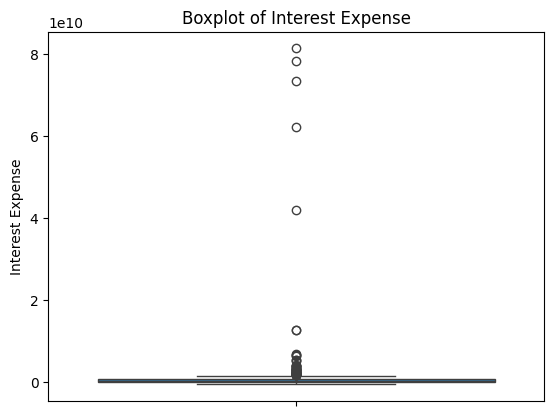

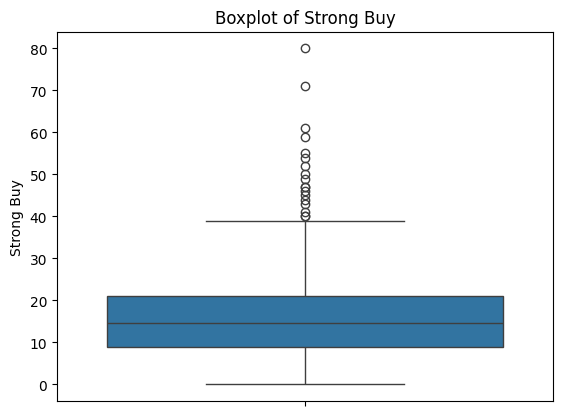

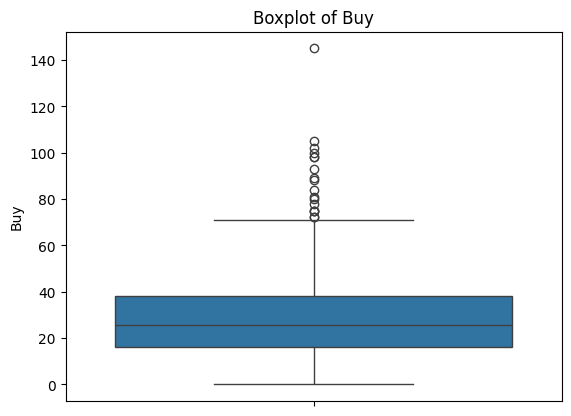

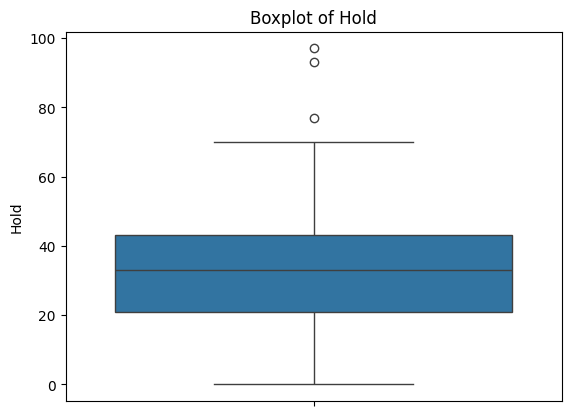

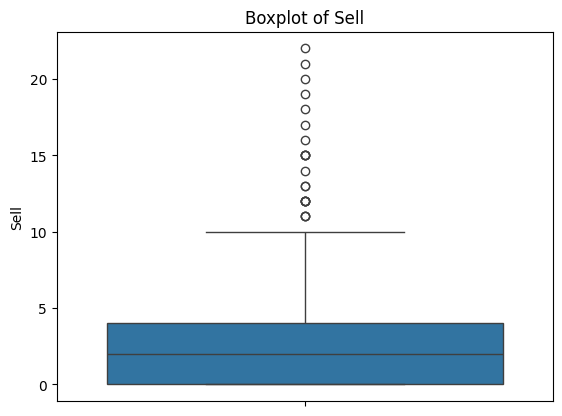

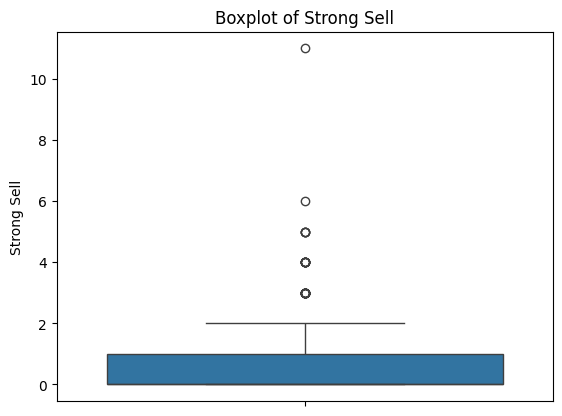

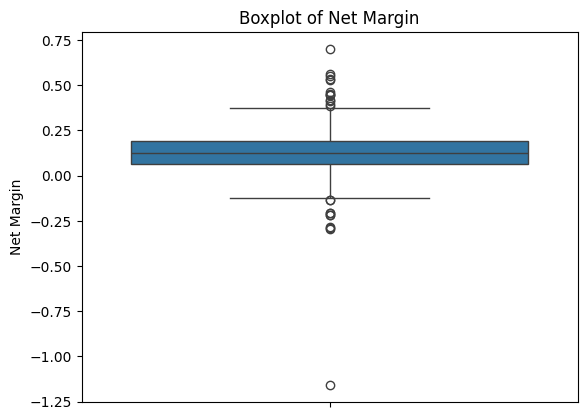

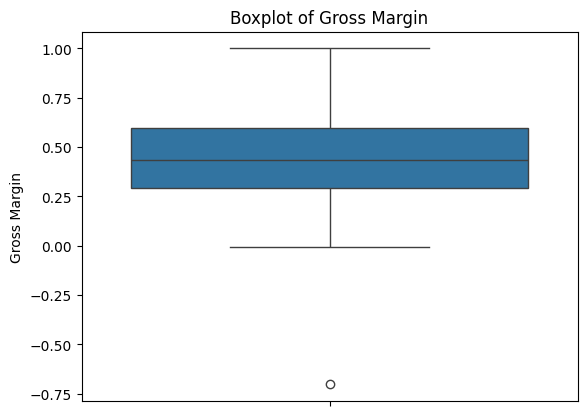

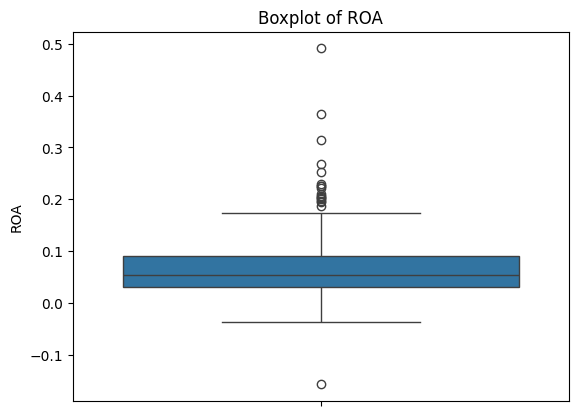

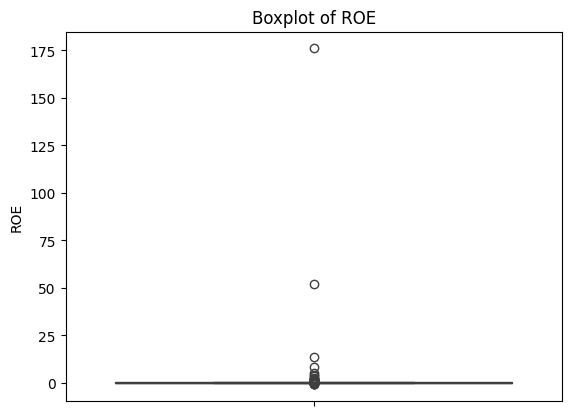

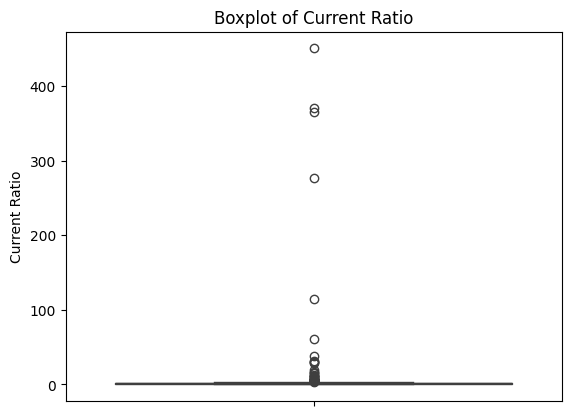

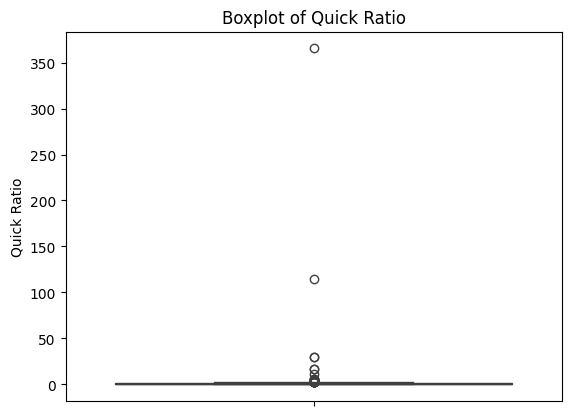

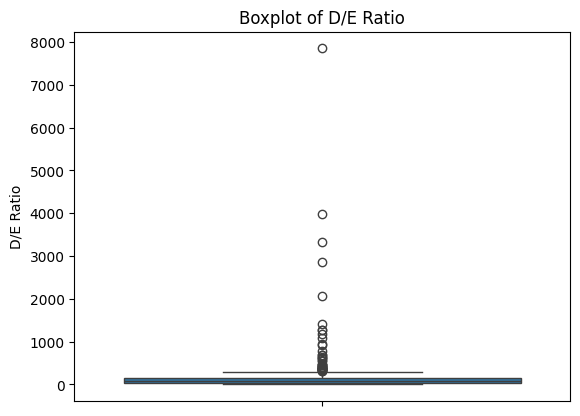

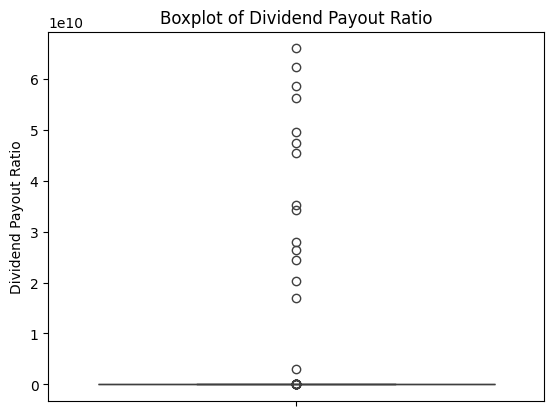

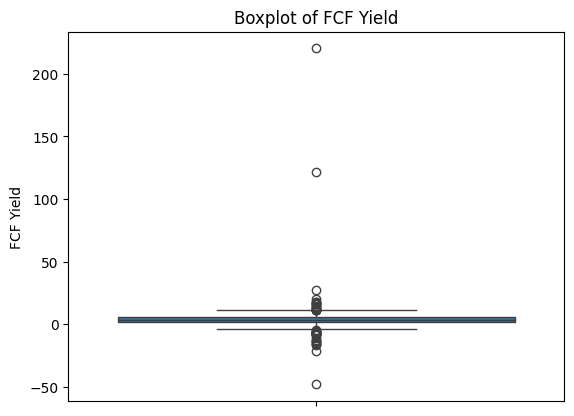

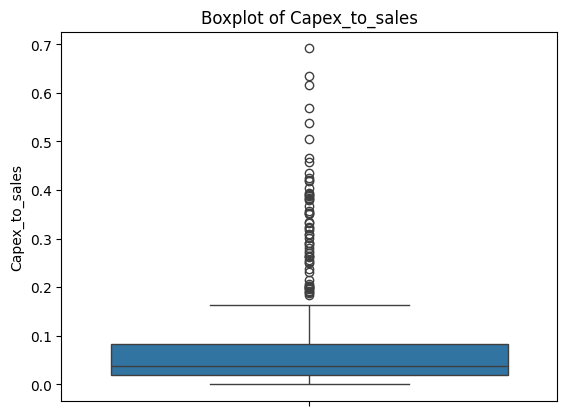

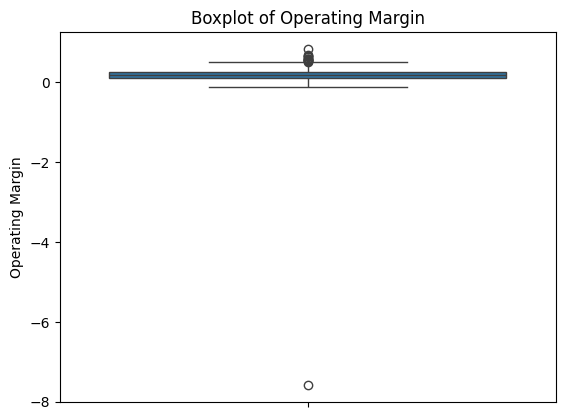

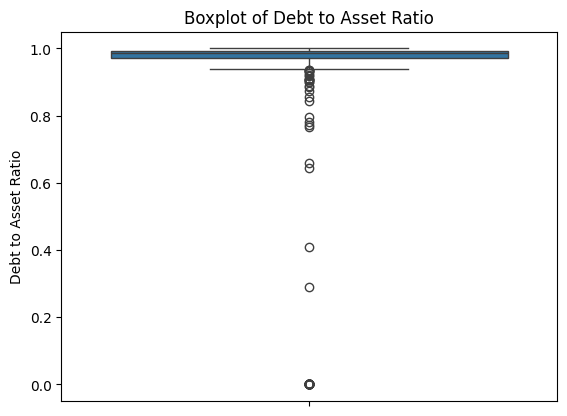

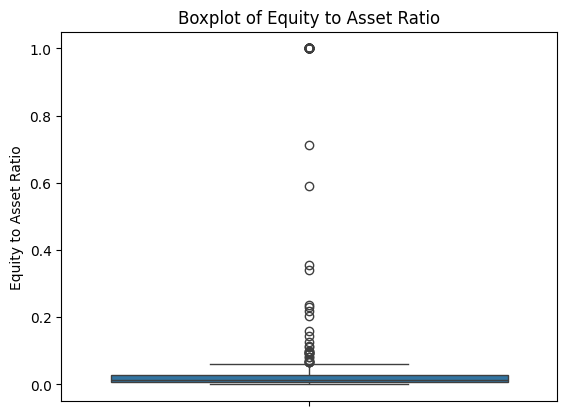

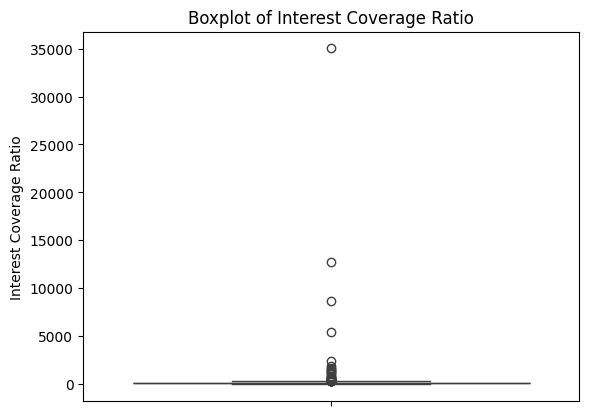

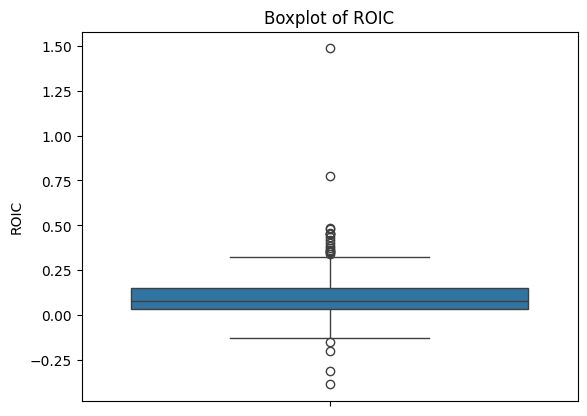

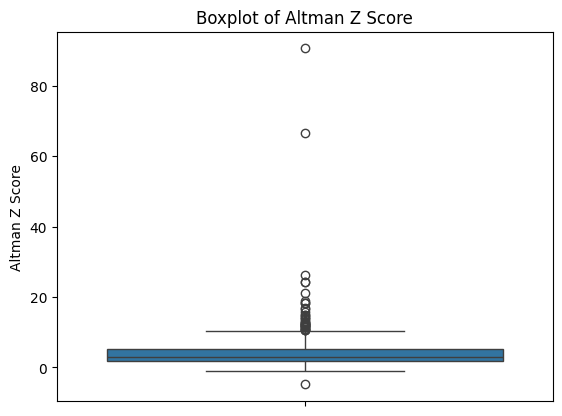

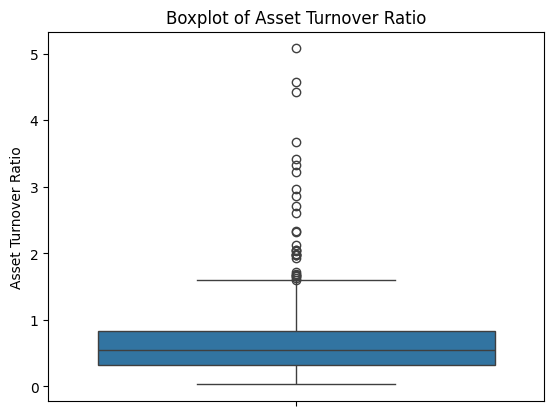

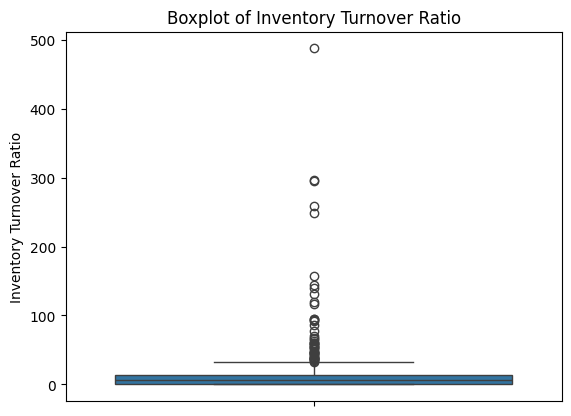

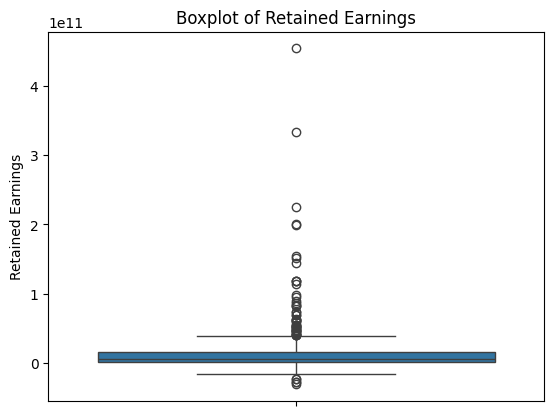

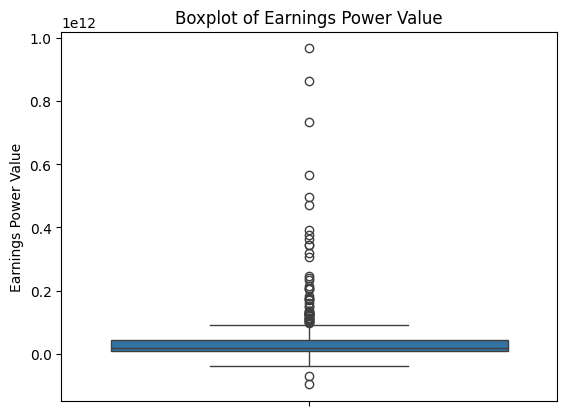

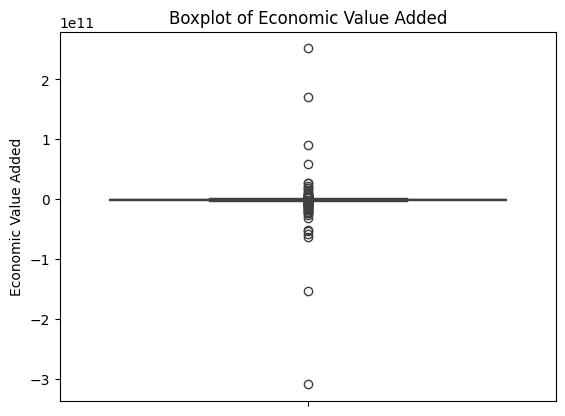

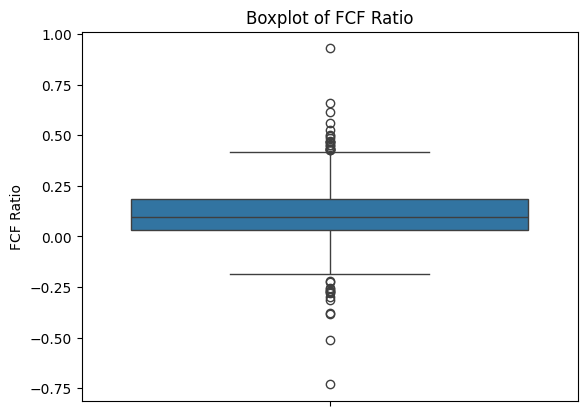

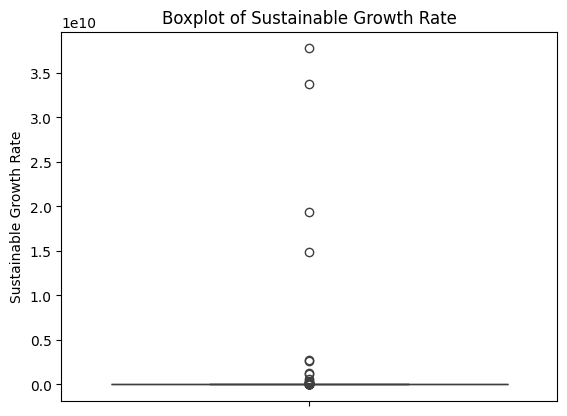

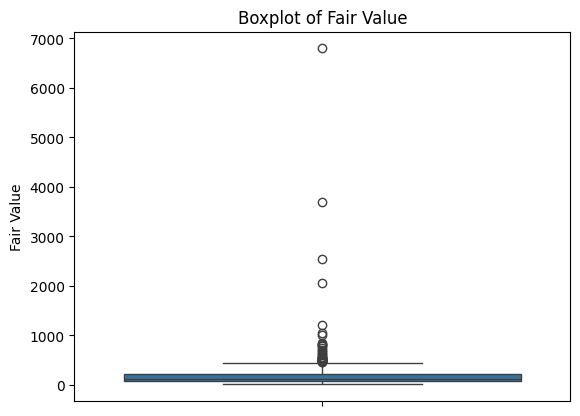

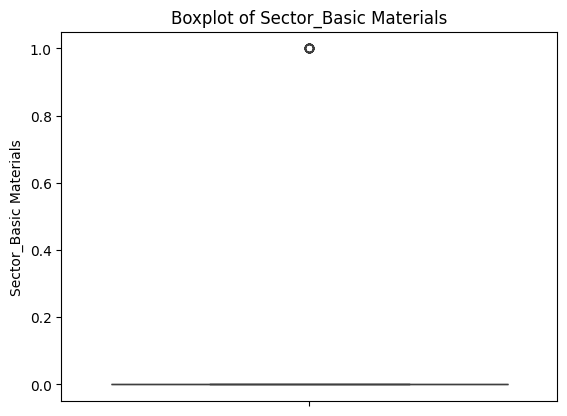

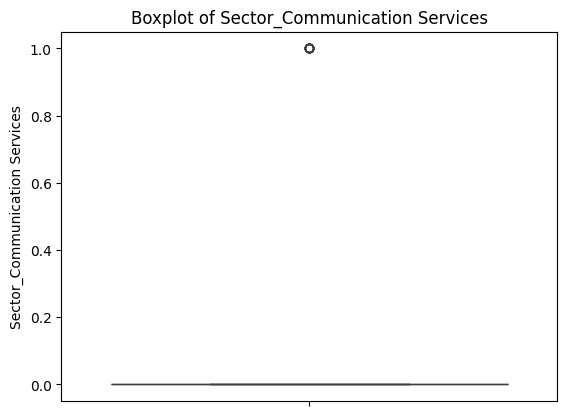

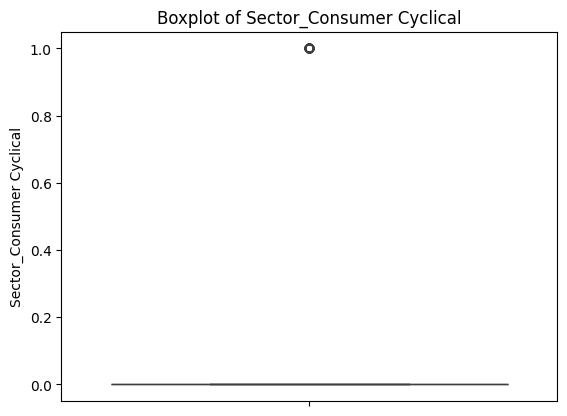

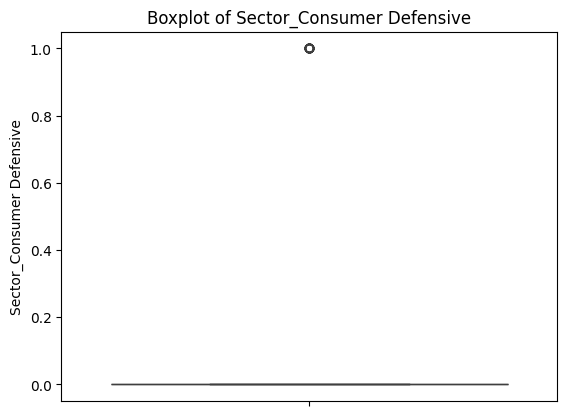

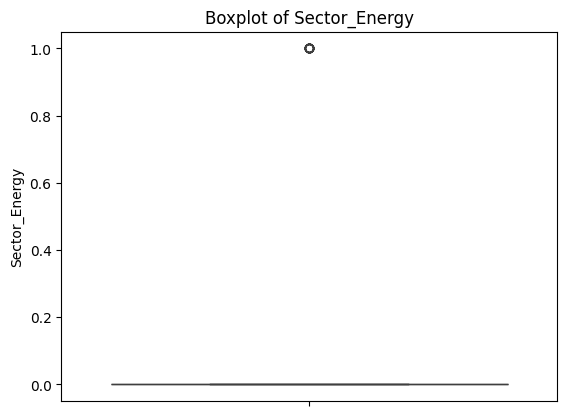

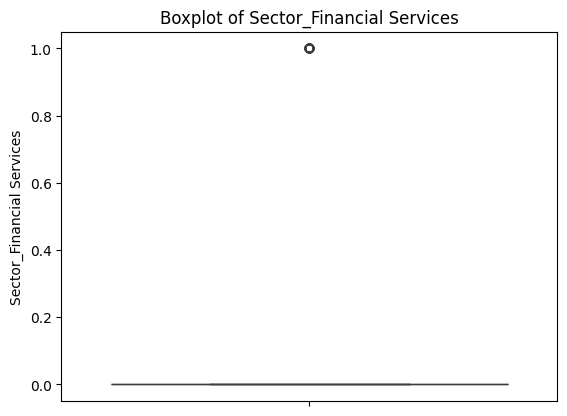

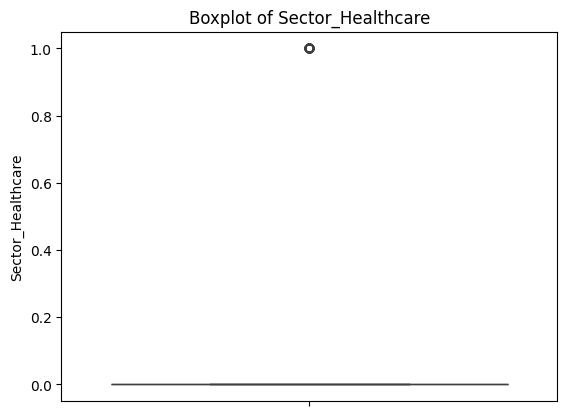

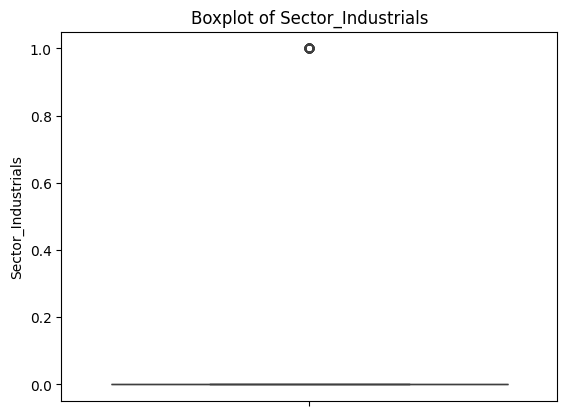

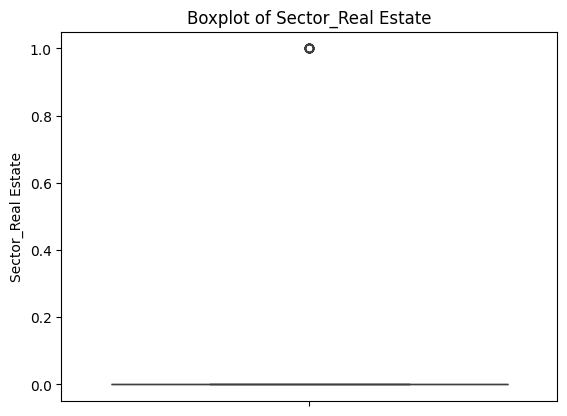

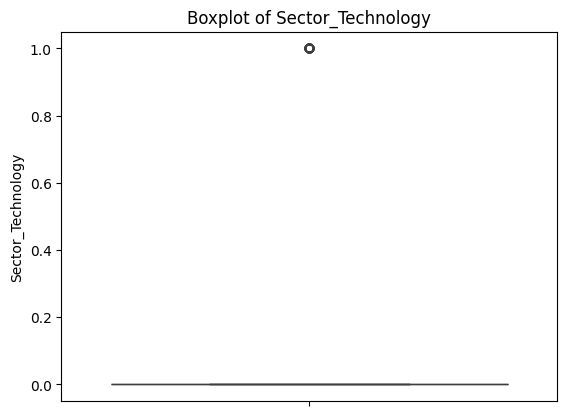

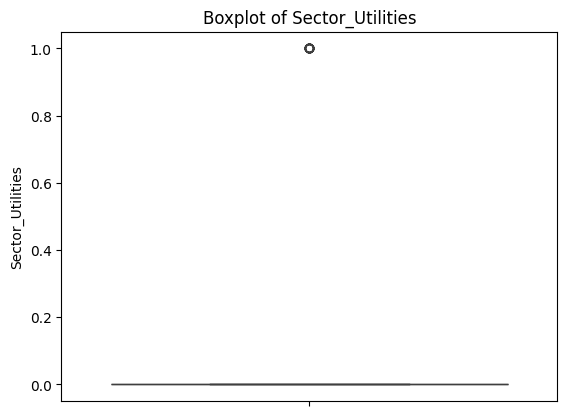

/home/odhran_user/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; tot

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('./portfolio_value_fair_value_data.csv')

# Drop rows with any NaN values
df = df.dropna()

# Drop the ticker column
df = df.drop(columns=['Ticker'])

# Handle Categorical Variables
df = pd.get_dummies(df)
df = df.apply(pd.to_numeric, errors='coerce')

# Check for NaN values after conversion and drop rows with NaN values
df = df.dropna()
# Check for outliers
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Visualize distribution of key features
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Handle outliers if needed
# Example: Cap outliers
for col in df.select_dtypes(include=[np.number]).columns:
    upper_lim = df[col].quantile(0.99)
    lower_lim = df[col].quantile(0.01)
    df[col] = np.where(df[col] > upper_lim, upper_lim, df[col])
    df[col] = np.where(df[col] < lower_lim, lower_lim, df[col])

# Define features and target
X = df.drop(columns=['Fair Value'])
y = df['Fair Value']
features = X.columns

# Log transformation of skewed features
skewed_feats = X.apply(lambda x: np.abs(x.skew())).sort_values(ascending=False)
skewed_features = skewed_feats[skewed_feats > 0.75].index
for feat in skewed_features:
    X[feat] = np.log1p(X[feat])

# Check for any remaining NaN values after log transformation
X = X.fillna(0)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature selection using XGBoost
selection_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
selection_model.fit(X_train, y_train)
sel = SelectFromModel(selection_model, threshold="mean", prefit=True)
X_train_selected = sel.transform(X_train)
X_test_selected = sel.transform(X_test)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Use KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=kf, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train_selected, y_train)

# Best parameters
best_params = grid_search.best_params_

# Evaluate the model
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_selected)

mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"Best Hyperparameters: {best_params}")
print(f"XGBoost Model Performance - MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_selected, y_train)

# Combine models using Voting Regressor
voting_regressor = VotingRegressor([('xgb', best_xgb), ('rf', rf)])
voting_regressor.fit(X_train_selected, y_train)

# Evaluate the combined model
y_pred_voting = voting_regressor.predict(X_test_selected)

mae_voting = mean_absolute_error(y_test, y_pred_voting)
mse_voting = mean_squared_error(y_test, y_pred_voting)
r2_voting = r2_score(y_test, y_pred_voting)

print(f"Voting Regressor Model Performance - MAE: {mae_voting:.2f}, MSE: {mse_voting:.2f}, R²: {r2_voting:.2f}")


Voting Regressor Model Performance - MAE: 60.90, MSE: 22602.13, R²: 0.68
